# Imports

In [93]:
import os
import pandas as pd
import numpy as np
import string,gzip,pickle,time,json,re,nltk
from nltk.corpus import stopwords
from nltk.stem import *
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm
from math import sqrt
from joblib import Parallel, delayed
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from spellchecker import SpellChecker
from datetime import datetime
import matplotlib.pyplot as plt

regex_tokenizer = RegexpTokenizer(r'[a-zA-Z]+')   
local_stopwords = set(stopwords.words('english'))
local_stopwords = [re.sub(r'[^\w\s]','', i) for i in local_stopwords]
stemmer = PorterStemmer()

# Text processing functions

In [130]:
#tokenize review
def RemoveHashURLMail(sentence):
    sentence = sentence.lower();
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = re.sub(r"@\S+", "", sentence)
    sentence = re.sub(r"#\S+", "", sentence)
    #sentence = list(map( lambda word: re.sub('[^a-zA-Z]+', '', word) ,sentence))
    return sentence.strip()

def TokenizeSentence(sentence):
    sentence = regex_tokenizer.tokenize(sentence);
    #sentence = list(map( lambda word: re.sub('[^a-zA-Z]+', '', word) ,sentence))
    return sentence

def RemoveStopwords():
    sentence = list(filter(lambda word: word not in local_stopwords, sentence))
    
def RemoveNonAlphaNonEnglish(sentence):
    sentence = list(filter(lambda word: word.isalpha, sentence))
    sentence = list(filter( lambda word: isEnglish(word) ,sentence))
    return sentence

def StemSentence(sentence):
    sentence = [stemmer.stem(word) for word in sentence];
    return sentence

def isEnglish(sentence):
    return sentence.translate(string.punctuation).isalnum();

def GenerateNgrams(sentence, n_gram_length=1):
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in sentence.split(" ") if token != ""]
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[tokens[i:] for i in range(n_gram_length)])
    return [" ".join(ngram) for ngram in ngrams]

# 1. Data Preprocessing
### Data is processed in memory joblib is used to proces multiply tweets at once

## 1.1 JSON to dataframe

In [41]:
tweetFilePath = r'C:\Users\Andreas\Python\DSF\Assignment\data\geotagged_tweets_20160812-0912.jsons' 

with open(tweetFilePath) as f:
    tweetsFile = f.readlines()
#using parallel processing
tweetsJSON = [Parallel(n_jobs=16)(delayed(json.loads)(tweet) for tweet in tqdm(tweetsFile))]
tweetsFile = []

100%|██████████| 657307/657307 [01:53<00:00, 5785.86it/s]


In [128]:
#defining helper functions for feature extraction
def ExtractPlaceFullName(tweet):
    try:
        return tweet['place']['full_name']
    except Exception as e:
        return ''  
    
def ExtractPlaceName(tweet):
    try:
        return tweet['place']['name']
    except Exception as e:
        return ''  
       
def ExtractCountry(tweet):
    try:
        return tweet['place']['country']
    except Exception as e:
        return ''   
    
def ExtractScreenName(mentions):
    try:
        return [mention['screen_name'].lower() for mention in mentions]
    except Exception as e:
        return []    
    
def ExtractHashtag(mentions):
    try:
        return [mention['text'].lower() for mention in mentions]
    except Exception as e:
        return []
    


In [43]:
#extracting usefull features from teweets
tweetText = [ tweet['text'] for tweet in  tweetsJSON[0]]
tweetTimestamp = [  datetime.strptime(tweet['created_at'],'%a %b %d %H:%M:%S +0000 %Y') for tweet in  tweetsJSON[0]]
tweetPlaceFullName= [ExtractPlaceFullName(tweet) for tweet in  tweetsJSON[0]]
tweetPlaceName= [ExtractPlaceName(tweet) for tweet in  tweetsJSON[0]]
tweetPlaceCountry = [ExtractCountry(tweet) for tweet in  tweetsJSON[0]]
tweetIsQuoteStatus = [tweet['is_quote_status'] for tweet in  tweetsJSON[0]]
tweetIsRetweeted = [tweet['retweeted'] for tweet in  tweetsJSON[0]]
tweetUserID = [tweet['user']['id'] for tweet in  tweetsJSON[0]]
tweetFollowersCount = [tweet['user']['followers_count'] for tweet in  tweetsJSON[0]]
tweetEntities = [ExtractScreenName(entity) for entity in [entity['user_mentions'] for entity in [tweet['entities'] for tweet in  tweetsJSON[0]]]]
tweetHashtags = [ExtractHashtag(entity) for entity in [entity['hashtags'] for entity in [tweet['entities'] for tweet in  tweetsJSON[0]]]]
tweetsDataframe = pd.DataFrame({"userID":tweetUserID,
                                "followersCount":tweetFollowersCount,
                                "text":tweetText,
                                "tDatetime":tweetTimestamp,
                                "country":tweetPlaceCountry,
                                "placeFullName":tweetPlaceFullName,
                                "placeName":tweetPlaceName,
                                "isRetweeted":tweetIsRetweeted,
                                "isQuote":tweetIsQuoteStatus,
                                "entities":tweetEntities,
                                "hashtags":tweetHashtags})


## 1.2 Add state name

### Tweets that are from outside the US are removed resulting

### A list of State names with responding abbrevation is retrieved from
https://www.factmonster.com/us/postal-information/state-abbreviations-and-state-postal-codes

In [145]:
stateCodeToNames = pd.read_html('https://www.factmonster.com/us/postal-information/state-abbreviations-and-state-postal-codes',header=0)[0]
stateCodeToNames.set_index('Postalcode',inplace = True)

In [151]:
def getState(placeFullName,country):
    state =''
    if placeFullName[-3:-2] == ' ' and country == 'United States':
        stateAbbr = placeFullName[-2:];
        if stateAbbr in stateCodeToNames.index:
            state = stateCodeToNames.loc[stateAbbr].State
    elif country == 'United States':
        str.find(placeFullName,',')
        state = placeFullName[0:str.find(placeFullName,',')]
        if state not in stateCodeToNames.State.tolist():
            state = ''
    return state

In [ ]:
tweetState = [getState(placeFullName,country) for placeFullName,country in tqdm(tweetsDataframe[['placeFullName','country']].values)]
tweetsDataframe['state'] = tweetState

In [155]:
#removing all tweets from outside the us
tweetsDataframe= tweetsDataframe[tweetsDataframe['state'] != '']
tweetsDataframe.to_pickle('tweetsPickle.pickle')

## 1.3 Deduce who tweet is about

### Simply version is based on partial string matching
### More complex version is based on a vector space model

In [3]:
#creating a few indicators if hillary clinton or donald trump is mentioned
tweetsDataframe['hasHillary'] = tweetsDataframe.text.str.contains('@HillaryClinton')
tweetsDataframe['hasDonaldTrump'] = tweetsDataframe.text.str.contains('@realDonaldTrump')

tweetsDataframe['mentionsCandidate'] = 'Both'
tweetsDataframe['mentionsCandidate'][tweetsDataframe['hasDonaldTrump'] & ~tweetsDataframe['hasHillary']] = 'Donald Trump'
tweetsDataframe['mentionsCandidate'][ ~tweetsDataframe['hasDonaldTrump'] & tweetsDataframe['hasHillary']] = 'Hillary Clinton'

C:\Users\Andreas\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Andreas\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [150]:
#remove all tweets that don't mention anyone or anything
tweetsDataframe = tweetsDataframe[[len(t) >= 1 for t in tweetsDataframe['hashtags'] + tweetsDataframe['entities']]]
tweetsDataframe.to_pickle('tweetsPickle_onlymentions.pickle')

### finding the 30 most common hashtags or mentions 
using the count vectorizer to create a document term matrix this results in a spase matrix

then we can extract our list from there

In [ ]:
tweetsDataframe = pd.read_pickle('tweetsPickle_onlymentions.pickle')

In [5]:
vectorizer=  CountVectorizer();
tweetTDM = vectorizer.fit_transform([' '.join(t) for t in tweetsDataframe['allEntities']])

In [7]:
keywordCounts= np.asarray(tweetTDM.sum(axis=0))[0]
keywordRank = np.argsort(np.asarray(tweetTDM.sum(axis=0)))[0].tolist()
featureNames = vectorizer.get_feature_names()

In [8]:
wordList = [featureNames[i] for i in keywordCounts.argsort()[::-1][:30]]
countList = [keywordCounts[i] for i in keywordCounts.argsort()[::-1][:30]]
print(dict(zip(wordList,countList)))

{'realdonaldtrump': 291691, 'hillaryclinton': 141011, 'trump': 48823, 'foxnews': 24050, 'nevertrump': 20350, 'cnn': 19618, 'maga': 17740, 'imwithher': 16963, 'neverhillary': 14280, 'hillary': 12814, 'trumppence16': 12603, 'crookedhillary': 10915, 'donaldtrump': 10584, 'seanhannity': 8438, 'kellyannepolls': 7773, 'msnbc': 7471, 'potus': 6822, 'gop': 6022, 'trumptrain': 5560, 'politico': 4586, 'nytimes': 4579, 'mike_pence': 4005, 'reince': 3842, 'morning_joe': 3750, 'dumptrump': 3629, 'makeamericagreatagain': 3561, 'erictrump': 3322, 'danscavino': 3295, 'greta': 3236, 'donaldjtrumpjr': 3218}


### First trying LDA on hastags / mentions

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

Can we identify the candidates from the resulting topics?

In [17]:
nKeywords = 400
lda = LDA(n_components=20, n_jobs=-1)
lda.fit(tweetTDM.T[keywordCounts.argsort()[::-1][:nKeywords]].T)

In [14]:
def printTopics(model, vectorizer):
    words  = [featureNames[i] for i in keywordCounts.argsort()[::-1][:nKeywords]]
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-2 - 1:-1]]))

In [15]:
printTopics(lda,vectorizer)


Topic #0:
hillary obama

Topic #1:
imwithher strongertogether

Topic #2:
nevertrump realdonaldtrump

Topic #3:
realdonaldtrump hillaryclinton

Topic #4:
trumppence16 hfa

Topic #5:
realdonaldtrump hillaryclinton

Topic #6:
neverhillary youtube

Topic #7:
cnn realdonaldtrump

Topic #8:
makeamericagreatagain trumptrain

Topic #9:
maga realdonaldtrump

Topic #10:
realdonaldtrump donaldtrump

Topic #11:
realdonaldtrump kellyannepolls

Topic #12:
crookedhillary neverhillary

Topic #13:
realdonaldtrump hillaryclinton

Topic #14:
realdonaldtrump morning_joe

Topic #15:
realdonaldtrump seanhannity

Topic #16:
hillaryclinton foxnews

Topic #17:
trump seanspicer

Topic #18:
realdonaldtrump colmorrisdavis

Topic #19:
realdonaldtrump foxandfriends


### Topics are manually allotted to candiates

In [53]:
hillaryTopics = [0,1,6,12,16]
trumpTopics = [2,4,7,8,9,10,11,14,15,17,18,19]
both = [3,5,13]
topics= {}

for i in hillaryTopics:
    topics[i] = 'Hillary Clinton'    
for i in trumpTopics:
    topics[i] = 'Donald Trump'  
for i in both:
    topics[i] = 'Both'  

In [88]:
allotTopics = lda.transform(tweetTDM.T[keywordCounts.argsort()[::-1][:nKeywords]].T)
tweetCandidate = allotTopics.argmax(axis=1)
tweetsDataframe['candidate'] = [topics[i] for i in tweetTopics]

([<matplotlib.patches.Wedge at 0x24d9efa5828>,
 [Text(-0.324909,-1.05092,'Donald Trump'),
  Text(0.579436,0.935015,'Hillary Clinton'),
  Text(-0.695018,0.978238,'Both')],
 [Text(-0.177223,-0.573229,'62.7%'),
  Text(0.316056,0.510008,'29.2%'),
  Text(-0.405427,0.570639,'8.1%')])

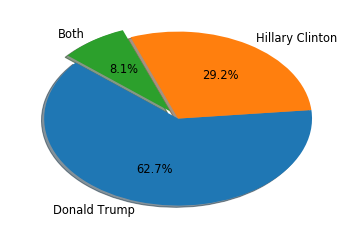

In [125]:
explode = (0, 0, 0.1)
# Plot
plt.pie(tweetsDataframe.candidate.value_counts().tolist(), 
        explode=explode, 
        labels=tweetsDataframe.candidate.value_counts().keys(), 
        autopct='%1.1f%%',
        shadow=True, 
        startangle=140)

### Trying  kmeans for unsupervised clustering

kmeans https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
![Alt Text](https://media.giphy.com/media/3NKUcoyBzkXQc/giphy.gif)


In [298]:
from sklearn.cluster import KMeans,MeanShift

In [291]:
nKeywords = 100
tweetTDMReduced = tweetTDM.T[keywordCounts.argsort()[::-1][:nKeywords]].T.toarray()
words = [featureNames[i] for i in keywordCounts.argsort()[::-1][:nKeywords]]

In [292]:
tweetClusters = KMeans(n_clusters=30, random_state=0, algorithm='full').fit(tweetTDMReduced)

In [296]:
def printClusters(tweetClusters):
    for cluster in tweetClusters.cluster_centers_:
        print('cluster {} words: '.format(cnt) +' '.join([words[i] for i in np.nonzero(cluster >= 0.90)[0].tolist()]))

In [297]:
printClusters(tweetClusters)

cluster 1 words: realdonaldtrump
cluster 2 words: hillaryclinton
cluster 3 words: nevertrump
cluster 4 words: donaldtrump
cluster 5 words: 
cluster 6 words: realdonaldtrump cnn
cluster 7 words: neverhillary
cluster 8 words: trump
cluster 9 words: hillary
cluster 10 words: neverhillary
cluster 11 words: realdonaldtrump morningmika
cluster 12 words: realdonaldtrump hillaryclinton
cluster 13 words: imwithher
cluster 14 words: maga
cluster 15 words: realdonaldtrump foxnews


## 1.4 Tokenize and stem tweets and remove stopwords
### In this step the tweets are preprocesed to allow for topic modelling

In [ ]:
tweetsPlainText = Parallel(n_jobs=16)(delayed(RemoveHashURLMail)(text) for text in tqdm(tweetsDataframe['text']))
tweetsDataframe['plainText'] =tweetsPlainText

In [ ]:
tweetsTokenized = Parallel(n_jobs=16)(delayed(TokenizeSentence)(text) for text in tqdm(tweetsDataframe['plainText']))
tweetsDataframe['textTokenized'] = tweetsTokenized

In [ ]:
tweetsTokenizedStemmed = Parallel(n_jobs=16)(delayed(StemSentence)(text) for text in tqdm(tweetsDataframe['textTokenized']))
tweetsDataframe['textTokenizedStemmed'] = tweetsTokenizedStemmed

In [135]:
tweetsDataframe.to_pickle('tweetsPickle_onlymentions.pickle')

## 1.5 Additional features

## Sentiment
### https://github.com/cjhutto/vaderSentiment
### VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media


In [197]:
!pip install vaderSentiment

You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [136]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

### Vader works with emoticons

### analyser.polarity_scores(':) hillary')

{'neg': 0.0, 'neu': 0.25, 'pos': 0.75, 'compound': 0.4588}

### analyser.polarity_scores(':( hillary')

{'neg': 0.744, 'neu': 0.256, 'pos': 0.0, 'compound': -0.4404}


In [137]:
tweetsSentiment = [ analyser.polarity_scores(tweet) for tweet in tqdm(tweetsDataframe['plainText'])]
tweetsDataframe['vaderSentiment'] = [sentiment['compound'] for sentiment in tweetsSentiment]



  0%|          | 0/541073 [00:00<?, ?it/s]

  0%|          | 469/541073 [00:00<01:55, 4688.95it/s]

  0%|          | 892/541073 [00:00<01:58, 4540.81it/s]

  0%|          | 1357/541073 [00:00<01:58, 4572.71it/s]

  0%|          | 1824/541073 [00:00<01:57, 4601.17it/s]

  0%|          | 2227/541073 [00:00<02:02, 4413.04it/s]

  1%|          | 2710/541073 [00:00<01:58, 4530.21it/s]

  1%|          | 3155/541073 [00:00<01:59, 4505.54it/s]

  1%|          | 3623/541073 [00:00<01:57, 4556.19it/s]

  1%|          | 4107/541073 [00:00<01:55, 4637.47it/s]

  1%|          | 4616/541073 [00:01<01:52, 4764.13it/s]

  1%|          | 5122/541073 [00:01<01:50, 4848.88it/s]

  1%|          | 5636/541073 [00:01<01:48, 4932.49it/s]

  1%|          | 6141/541073 [00:01<01:47, 4966.71it/s]

  1%|          | 6663/541073 [00:01<01:46, 5039.88it/s]

  1%|▏         | 7181/541073 [00:01<01:45, 5080.78it/s]

  1%|▏         | 7732/541073 [00:01<01:42, 5202.02it/s]

  2%|▏         | 8280/541073 [00:01<01:40, 5

 28%|██▊       | 149024/541073 [00:28<01:14, 5244.29it/s]

 28%|██▊       | 149550/541073 [00:28<01:15, 5201.91it/s]

 28%|██▊       | 150114/541073 [00:28<01:13, 5325.68it/s]

 28%|██▊       | 150696/541073 [00:28<01:11, 5464.57it/s]

 28%|██▊       | 151314/541073 [00:28<01:08, 5660.84it/s]

 28%|██▊       | 151884/541073 [00:29<01:08, 5655.26it/s]

 28%|██▊       | 152452/541073 [00:29<01:09, 5595.33it/s]

 28%|██▊       | 153014/541073 [00:29<01:10, 5471.39it/s]

 28%|██▊       | 153563/541073 [00:29<01:11, 5395.84it/s]

 28%|██▊       | 154115/541073 [00:29<01:11, 5432.13it/s]

 29%|██▊       | 154662/541073 [00:29<01:10, 5443.06it/s]

 29%|██▊       | 155208/541073 [00:29<01:11, 5399.27it/s]

 29%|██▉       | 155749/541073 [00:29<01:12, 5291.14it/s]

 29%|██▉       | 156280/541073 [00:29<01:13, 5249.30it/s]

 29%|██▉       | 156806/541073 [00:30<01:13, 5205.21it/s]

 29%|██▉       | 157380/541073 [00:30<01:11, 5354.69it/s]

 29%|██▉       | 157917/541073 [00:30<01:13, 5203.09it/s

 55%|█████▌    | 299124/541073 [00:56<00:46, 5188.14it/s]

 55%|█████▌    | 299644/541073 [00:56<00:46, 5160.42it/s]

 55%|█████▌    | 300174/541073 [00:57<00:46, 5201.17it/s]

 56%|█████▌    | 300747/541073 [00:57<00:44, 5348.94it/s]

 56%|█████▌    | 301284/541073 [00:57<00:45, 5291.52it/s]

 56%|█████▌    | 301864/541073 [00:57<00:44, 5434.12it/s]

 56%|█████▌    | 302410/541073 [00:57<00:44, 5409.13it/s]

 56%|█████▌    | 303032/541073 [00:57<00:42, 5628.95it/s]

 56%|█████▌    | 303599/541073 [00:57<00:42, 5624.03it/s]

 56%|█████▌    | 304164/541073 [00:57<00:42, 5631.13it/s]

 56%|█████▋    | 304730/541073 [00:57<00:41, 5639.67it/s]

 56%|█████▋    | 305296/541073 [00:57<00:43, 5402.82it/s]

 57%|█████▋    | 305849/541073 [00:58<00:43, 5439.99it/s]

 57%|█████▋    | 306396/541073 [00:58<00:43, 5400.16it/s]

 57%|█████▋    | 306938/541073 [00:58<00:44, 5279.34it/s]

 57%|█████▋    | 307468/541073 [00:58<00:44, 5222.65it/s]

 57%|█████▋    | 307996/541073 [00:58<00:44, 5239.37it/s

 83%|████████▎ | 447504/541073 [01:25<00:18, 5180.20it/s]

 83%|████████▎ | 448023/541073 [01:25<00:17, 5182.78it/s]

 83%|████████▎ | 448542/541073 [01:25<00:18, 5108.04it/s]

 83%|████████▎ | 449054/541073 [01:25<00:18, 5035.85it/s]

 83%|████████▎ | 449559/541073 [01:25<00:18, 4980.09it/s]

 83%|████████▎ | 450058/541073 [01:25<00:18, 4967.84it/s]

 83%|████████▎ | 450571/541073 [01:25<00:18, 5015.06it/s]

 83%|████████▎ | 451089/541073 [01:25<00:17, 5063.10it/s]

 83%|████████▎ | 451596/541073 [01:25<00:17, 5064.82it/s]

 84%|████████▎ | 452139/541073 [01:26<00:17, 5168.78it/s]

 84%|████████▎ | 452657/541073 [01:26<00:17, 5065.53it/s]

 84%|████████▍ | 453165/541073 [01:26<00:17, 5054.41it/s]

 84%|████████▍ | 453672/541073 [01:26<00:17, 4954.89it/s]

 84%|████████▍ | 454169/541073 [01:26<00:17, 4959.08it/s]

 84%|████████▍ | 454683/541073 [01:26<00:17, 5011.66it/s]

 84%|████████▍ | 455222/541073 [01:26<00:16, 5119.15it/s]

 84%|████████▍ | 455767/541073 [01:26<00:16, 5213.77it/s

In [ ]:
tweetsDataframe['vaderSentimentDummy'] = 'NEU'
tweetsDataframe['vaderSentimentDummy'][tweetsDataframe.vaderSentiment > 0.05] = 'POS'
tweetsDataframe['vaderSentimentDummy'][tweetsDataframe.vaderSentiment < -0.05]= 'NEG'

## textblob sentiment

In [17]:
!pip install textblob 

You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [139]:
from textblob import TextBlob
from textblob.sentiments import PatternAnalyzer,NaiveBayesAnalyzer

patternAnalyzer = PatternAnalyzer()

In [140]:
polarity = [TextBlob(tweet,analyzer = patternAnalyzer).sentiment.polarity for tweet in tqdm(tweetsDataframe['plainText'])]
tweetsDataframe['textblobSentiment'] = polarity 



  0%|          | 0/541073 [00:00<?, ?it/s]

  0%|          | 8/541073 [00:00<1:52:44, 79.98it/s]

  0%|          | 470/541073 [00:00<1:19:26, 113.42it/s]

  0%|          | 907/541073 [00:00<56:10, 160.24it/s]  

  0%|          | 1324/541073 [00:00<39:56, 225.21it/s]

  0%|          | 1765/541073 [00:00<28:33, 314.83it/s]

  0%|          | 2198/541073 [00:00<20:35, 436.16it/s]

  0%|          | 2640/541073 [00:00<15:00, 597.74it/s]

  1%|          | 3064/541073 [00:00<11:08, 805.25it/s]

  1%|          | 3495/541073 [00:00<08:24, 1065.05it/s]

  1%|          | 3929/541073 [00:01<06:30, 1376.67it/s]

  1%|          | 4375/541073 [00:01<05:09, 1736.07it/s]

  1%|          | 4828/541073 [00:01<04:11, 2130.11it/s]

  1%|          | 5283/541073 [00:01<03:31, 2534.48it/s]

  1%|          | 5734/541073 [00:01<03:03, 2917.74it/s]

  1%|          | 6181/541073 [00:01<02:44, 3256.99it/s]

  1%|          | 6636/541073 [00:01<02:30, 3553.02it/s]

  1%|▏         | 7083/541073 [00:01<02:21, 3785.70

 12%|█▏        | 63727/541073 [00:14<01:45, 4526.56it/s]

 12%|█▏        | 64181/541073 [00:14<01:45, 4503.46it/s]

 12%|█▏        | 64632/541073 [00:14<01:45, 4504.97it/s]

 12%|█▏        | 65111/541073 [00:14<01:43, 4586.67it/s]

 12%|█▏        | 65571/541073 [00:14<01:43, 4576.65it/s]

 12%|█▏        | 66040/541073 [00:14<01:43, 4609.77it/s]

 12%|█▏        | 66502/541073 [00:14<01:43, 4598.59it/s]

 12%|█▏        | 66963/541073 [00:15<01:43, 4587.98it/s]

 12%|█▏        | 67427/541073 [00:15<01:42, 4603.29it/s]

 13%|█▎        | 67888/541073 [00:15<01:43, 4591.09it/s]

 13%|█▎        | 68350/541073 [00:15<01:42, 4599.32it/s]

 13%|█▎        | 68812/541073 [00:15<01:42, 4605.31it/s]

 13%|█▎        | 69273/541073 [00:15<01:42, 4592.73it/s]

 13%|█▎        | 69733/541073 [00:15<01:44, 4526.64it/s]

 13%|█▎        | 70209/541073 [00:15<01:42, 4593.91it/s]

 13%|█▎        | 70669/541073 [00:15<01:44, 4514.23it/s]

 13%|█▎        | 71123/541073 [00:15<01:43, 4521.60it/s]

 13%|█▎       

 35%|███▌      | 190347/541073 [00:42<01:19, 4405.88it/s]

 35%|███▌      | 190788/541073 [00:42<01:19, 4406.62it/s]

 35%|███▌      | 191234/541073 [00:42<01:19, 4409.89it/s]

 35%|███▌      | 191680/541073 [00:42<01:18, 4424.40it/s]

 36%|███▌      | 192123/541073 [00:42<01:18, 4425.59it/s]

 36%|███▌      | 192575/541073 [00:43<01:18, 4446.26it/s]

 36%|███▌      | 193020/541073 [00:43<01:18, 4407.51it/s]

 36%|███▌      | 193478/541073 [00:43<01:17, 4457.59it/s]

 36%|███▌      | 193931/541073 [00:43<01:17, 4478.77it/s]

 36%|███▌      | 194382/541073 [00:43<01:17, 4487.76it/s]

 36%|███▌      | 194831/541073 [00:43<01:17, 4448.13it/s]

 36%|███▌      | 195283/541073 [00:43<01:17, 4469.06it/s]

 36%|███▌      | 195748/541073 [00:43<01:16, 4519.21it/s]

 36%|███▋      | 196227/541073 [00:43<01:15, 4586.10it/s]

 36%|███▋      | 196687/541073 [00:43<01:15, 4576.38it/s]

 36%|███▋      | 197146/541073 [00:44<01:15, 4580.15it/s]

 37%|███▋      | 197605/541073 [00:44<01:15, 4541.75it/s

 59%|█████▊    | 316600/541073 [01:10<00:51, 4397.04it/s]

 59%|█████▊    | 317050/541073 [01:10<00:50, 4427.13it/s]

 59%|█████▊    | 317493/541073 [01:10<00:51, 4362.27it/s]

 59%|█████▉    | 317930/541073 [01:10<00:51, 4351.25it/s]

 59%|█████▉    | 318384/541073 [01:10<00:50, 4405.92it/s]

 59%|█████▉    | 318825/541073 [01:10<00:50, 4380.44it/s]

 59%|█████▉    | 319287/541073 [01:11<00:49, 4449.36it/s]

 59%|█████▉    | 319734/541073 [01:11<00:49, 4455.37it/s]

 59%|█████▉    | 320189/541073 [01:11<00:49, 4482.91it/s]

 59%|█████▉    | 320638/541073 [01:11<00:49, 4484.64it/s]

 59%|█████▉    | 321087/541073 [01:11<00:50, 4381.10it/s]

 59%|█████▉    | 321532/541073 [01:11<00:49, 4397.83it/s]

 60%|█████▉    | 321973/541073 [01:11<00:50, 4378.38it/s]

 60%|█████▉    | 322413/541073 [01:11<00:49, 4384.39it/s]

 60%|█████▉    | 322858/541073 [01:11<00:49, 4403.60it/s]

 60%|█████▉    | 323309/541073 [01:12<00:49, 4434.60it/s]

 60%|█████▉    | 323753/541073 [01:12<00:48, 4435.90it/s

 82%|████████▏ | 442010/541073 [01:38<00:23, 4291.38it/s]

 82%|████████▏ | 442459/541073 [01:38<00:22, 4348.69it/s]

 82%|████████▏ | 442910/541073 [01:38<00:22, 4395.32it/s]

 82%|████████▏ | 443384/541073 [01:38<00:21, 4492.90it/s]

 82%|████████▏ | 443835/541073 [01:38<00:21, 4483.88it/s]

 82%|████████▏ | 444305/541073 [01:38<00:21, 4536.98it/s]

 82%|████████▏ | 444774/541073 [01:39<00:21, 4581.52it/s]

 82%|████████▏ | 445239/541073 [01:39<00:20, 4601.55it/s]

 82%|████████▏ | 445700/541073 [01:39<00:20, 4549.13it/s]

 82%|████████▏ | 446156/541073 [01:39<00:21, 4484.92it/s]

 83%|████████▎ | 446605/541073 [01:39<00:21, 4486.35it/s]

 83%|████████▎ | 447054/541073 [01:39<00:20, 4487.02it/s]

 83%|████████▎ | 447503/541073 [01:39<00:21, 4447.71it/s]

 83%|████████▎ | 447949/541073 [01:39<00:21, 4424.47it/s]

 83%|████████▎ | 448392/541073 [01:39<00:21, 4399.58it/s]

 83%|████████▎ | 448833/541073 [01:39<00:21, 4389.12it/s]

 83%|████████▎ | 449273/541073 [01:40<00:21, 4289.42it/s

In [ ]:
tweetsDataframe['textblobSentimentDummy'] = 'NEU'
tweetsDataframe['textblobSentimentDummy'][tweetsDataframe.textblobSentiment > 0.05] = 'POS'
tweetsDataframe['textblobSentimentDummy'][tweetsDataframe.textblobSentiment < -0.05] = 'NEG'

In [156]:
tweetsDataframe.to_pickle('tweetsPickle_onlymentions_sent.pickle')